In [1]:
import csv
import os
import pandas as pd
import numpy as np
import sys
import openpyxl
import xlrd
import datetime
import math
import sklearn
import matplotlib.pyplot as plt



In [2]:
import zipfile as zf
#files = zf.ZipFile("C:/Users/Jacob/Projects/NHL Free Agency ML 2024/data.zip", 'r')
data_loc = 'C:/Users/Jacob/Projects/NHL Free Agency ML 2024/'
#files.extractall('C:/Users/Jacob/Projects/NHL Free Agency ML 2024/')
#files.close()

data_loc += 'data/'

In [3]:
def getColumnIndex(headers, column_name):
    index = -1
    for i in range(len(headers)):
        if headers[i] == column_name:
            index = i

    if index == -1:
        sys.exit('column not found in header list')
    
    return index

In [4]:
def Variance(test_list):
    mean = sum(test_list) / len(test_list) 
    res = sum((i - mean) ** 2 for i in test_list) / len(test_list)
    return res

In [5]:
def ScaleList(test_list):
    max_num = max(test_list)
    for i in range(len(test_list)):
        test_list[i] = test_list[i]/max_num

    return test_list

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
def oneHot(df, categorical_features):
    #categorical_features = ["POS", "TYPE", "CLAUSE", "EXPIRY"]
    one_hot = OneHotEncoder()
    transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder="passthrough")
    
    transformed_x = transformer.fit_transform(df)
    new_df = pd.DataFrame(transformed_x)
    return new_df

In [7]:
# Contract Stats
# every contract that has been signed since 2009 (active players only)
contract_df = pd.read_excel(data_loc + 'Contract Stats/NHL contract data.xlsx')
# Clean contract season stats
# Issue: 'PLAYERS' = X. First Last
temp1_df = contract_df['PLAYER'].str.split(" ", n=1, expand=True).rename(columns={0 : "first", 1 : "last"})       # split 'PLAYER' columnn by first and last name = [X. First, Last] and renam the columns
temp2_df = temp1_df['first'].str.split(".", n=1, expand=True).drop(columns=[0], axis=1)                           # split 1st column up = [X., First] and drop the 'X.' column
contract_df['PLAYER'] = temp2_df[1] + " " + temp1_df['last']                                                      # combine columns into 1 and replace 'PLAYER" column in original df

contract_df = contract_df.drop(columns=['EXP. YEAR', 'CAP HIT'], axis=1)

contract_df = contract_df.loc[:,~contract_df.columns.duplicated()].copy() # remove duplicate columns

# replace nan variable sin CLAUSE column with "-"
contract_df["CLAUSE"] = contract_df["CLAUSE"].fillna("-")
print(contract_df.head())

contract_headers = contract_df.columns.values.tolist()
full_contract_list = contract_df.values.tolist()

# fix weird name issue
for i in range(len(full_contract_list)):
    full_contract_list[i][0] = full_contract_list[i][0].replace(full_contract_list[i][0][:1], '')
    #print(str(i) + ". " + full_contract_list[i][0])

print(len(full_contract_list))

                PLAYER POS              TYPE   SIGNING DATE  SIGNING AGE   
0      Jalen Chatfield  RD  Standard (1-way)  Jun. 13, 2024           28  \
1          Kaapo Kakko  RW  Standard (1-way)  Jun. 13, 2024           23   
2     Angus Crookshank  LW  Standard (2-way)  Jun. 12, 2024           24   
3         Colten Ellis   G  Standard (2-way)  Jun. 11, 2024           23   
4   Mathias Laferrière   C  Standard (2-way)   Jun. 9, 2024           24   

  CLAUSE  LENGTH EXPIRY  CAP HIT %  
0      -       3    UFA      0.034  
1      -       1    RFA      0.027  
2      -       1    RFA      0.009  
3      -       1    RFA      0.009  
4      -       1    RFA      0.009  
1012


In [8]:
# Clean Contract Stats List

# change SIGNING DATE column to just the year
column_index = getColumnIndex(contract_headers, "SIGNING DATE")
for contract in full_contract_list:
    date = contract[column_index]
    if isinstance(date, datetime.date):
        year = date.year
    else:
        year = date[-4:]
    contract[column_index] = year


print(len(full_contract_list))
#full_contract_df = pd.DataFrame(full_contract_list, columns=contract_headers)

1012


In [9]:
# All Season Stats
games_played_threshold = 20

# Skaters
season_stats_skaters = []
# stats for every player for every season (2009-2024)
# Skaters:
skater_season_data_loc = data_loc + 'Season Stats/Skaters/'
for file in next(os.walk(skater_season_data_loc))[2]:
    if '~$' in file:
         continue
    else:
        temp_df = pd.read_excel(skater_season_data_loc + file, engine='openpyxl')
        temp_df.columns = temp_df.iloc[0] # make 1st row the columns (default excel file has 2 rows of headers)
        temp_df = temp_df.drop(0) # get rid of 1st row (b/c we just made it the column headers above)
        temp_df = temp_df.drop(columns = ['Rk', 'Age', 'Team', 'TOI', 'Pos', 'FO%'])
        temp_df = temp_df.drop(temp_df[temp_df['Player'] == 'Sebastian Aho'].index)
        temp_df = temp_df.drop_duplicates(keep=False)

         # debug
        for row in range(len(temp_df['Player'].values.tolist())):
            if temp_df['Player'].values.tolist()[row] == "Dylan Larkin":
                print(file + ":")
                print("    FOUND: " + temp_df['Player'].values.tolist()[row] + " (year: " + str(temp_df['Season'].values.tolist()[row]) + ") - GP: " + str(temp_df['GP'].values.tolist()[row]))
        
        temp_df = temp_df.drop(temp_df[temp_df['GP'] < games_played_threshold].index)
        
        # change df to a list (temporary)
        # its easier to append a list to the end of another list than it is to append a df to the end of another df
        temp_list = temp_df.values.tolist()
        season_headers_skaters = temp_df.columns.tolist()

        # Add list to the big list
        for i in range(len(temp_list)):
            season_stats_skaters.append(temp_list[i])

#season_stats_skaters_df = pd.DataFrame(season_stats_skaters, columns=season_headers_skaters)

sportsref_download (1).xlsx:
    FOUND: Dylan Larkin (year: 2018-19) - GP: 76
sportsref_download (1).xlsx:
    FOUND: Dylan Larkin (year: 2023-24) - GP: 68
sportsref_download (1).xlsx:
    FOUND: Dylan Larkin (year: 2021-22) - GP: 71
sportsref_download (12).xlsx:
    FOUND: Dylan Larkin (year: 2016-17) - GP: 80
sportsref_download (17).xlsx:
    FOUND: Dylan Larkin (year: 2020-21) - GP: 44
sportsref_download (2).xlsx:
    FOUND: Dylan Larkin (year: 2017-18) - GP: 82
sportsref_download (5).xlsx:
    FOUND: Dylan Larkin (year: 2019-20) - GP: 71
sportsref_download (7).xlsx:
    FOUND: Dylan Larkin (year: 2015-16) - GP: 80
sportsref_download.xlsx:
    FOUND: Dylan Larkin (year: 2022-23) - GP: 80


In [10]:
# All Season Stats

# Goalies:
season_stats_goalies = []
# stats for every goalie for every season (2009-2024)
goalie_season_data_loc = data_loc + 'Season Stats/Goalies/'
for file in next(os.walk(goalie_season_data_loc))[2]:
    if '~$' in file:
         continue
    else:
        temp_df = pd.read_excel(goalie_season_data_loc + file, engine='openpyxl')
        temp_df = temp_df.drop(columns = ['Rk', 'Age', 'Team'])
        temp_df = temp_df.drop(temp_df[temp_df['GP'] < games_played_threshold].index)

        # change df to a list (temporary)
        temp_list = temp_df.values.tolist()
        season_headers_goalies = temp_df.columns.tolist()
        
        # Add list to the big list
        for i in range(len(temp_list)):
            season_stats_goalies.append(temp_list[i])

#season_stats_goalies_df = pd.DataFrame(season_stats_goalies, columns=season_headers_goalies)

In [11]:
# Detailed Stats
# detailed stats for every player (2009-2024)
detailed_stats = []
folder_names = []
current_year = 2024
temp_year = current_year
num_folders = len(next(os.walk(data_loc + 'Detailed Stats/'))[1])
for i in range(num_folders):
    folder_names.append(str(temp_year))
    temp_year = temp_year - 1

for i in range(len(folder_names)):
    year = folder_names[i]
    temp_df = pd.read_csv( data_loc + 'Detailed Stats/'+year+'/skaters.csv')
    temp_df = temp_df.drop(temp_df[temp_df.situation == 'other'].index)
    temp_df = temp_df.drop(temp_df[temp_df.situation == '5on5'].index)
    temp_df = temp_df.drop(temp_df[temp_df.situation == '4on4'].index)
    temp_df = temp_df.drop(temp_df[temp_df.situation == '5on4'].index)
    temp_df = temp_df.drop(temp_df[temp_df.situation == '4on5'].index)

     # debug
    for row in range(len(temp_df['name'].values.tolist())):
        if temp_df['name'].values.tolist()[row] == "Dylan Larkin":
            print(year + ":")
            print("    FOUND: " + temp_df['name'].values.tolist()[row] + " (year: " + str(temp_df['season'].values.tolist()[row]) + ") - GP: " + str(temp_df['games_played'].values.tolist()[row]))
    
    temp_df = temp_df.drop(temp_df[temp_df.games_played < games_played_threshold].index)
    # get rid of spcific columns (see excel documents for details)
    # all_columns = ['playerId', 'season', 'name', 'team', 'position', 'situation', 'games_played', 'icetime', 'shifts', 'gameScore', 'onIce_xGoalsPercentage', 'offIce_xGoalsPercentage', 'onIce_corsiPercentage', 'offIce_corsiPercentage', 'onIce_fenwickPercentage', 'offIce_fenwickPercentage', 'iceTimeRank', 'I_F_xOnGoal', 'I_F_xGoals', 'I_F_xRebounds', 'I_F_xFreeze', 'I_F_xPlayStopped', 'I_F_xPlayContinuedInZone', 'I_F_xPlayContinuedOutsideZone', 'I_F_flurryAdjustedxGoals', 'I_F_scoreVenueAdjustedxGoals', 'I_F_flurryScoreVenueAdjustedxGoals', 'I_F_primaryAssists', 'I_F_secondaryAssists', 'I_F_shotsOnGoal', 'I_F_missedShots', 'I_F_blockedShotAttempts', 'I_F_shotAttempts', 'I_F_points', 'I_F_goals', 'I_F_rebounds', 'I_F_reboundGoals', 'I_F_freeze', 'I_F_playStopped', 'I_F_playContinuedInZone', 'I_F_playContinuedOutsideZone', 'I_F_savedShotsOnGoal', 'I_F_savedUnblockedShotAttempts', 'penalties', 'I_F_penalityMinutes', 'I_F_faceOffsWon', 'I_F_hits', 'I_F_takeaways', 'I_F_giveaways', 'I_F_lowDangerShots', 'I_F_mediumDangerShots', 'I_F_highDangerShots', 'I_F_lowDangerxGoals', 'I_F_mediumDangerxGoals', 'I_F_highDangerxGoals', 'I_F_lowDangerGoals', 'I_F_mediumDangerGoals', 'I_F_highDangerGoals', 'I_F_scoreAdjustedShotsAttempts', 'I_F_unblockedShotAttempts', 'I_F_scoreAdjustedUnblockedShotAttempts', 'I_F_dZoneGiveaways', 'I_F_xGoalsFromxReboundsOfShots', 'I_F_xGoalsFromActualReboundsOfShots', 'I_F_reboundxGoals', 'I_F_xGoals_with_earned_rebounds', 'I_F_xGoals_with_earned_rebounds_scoreAdjusted', 'I_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted', 'I_F_shifts', 'I_F_oZoneShiftStarts', 'I_F_dZoneShiftStarts', 'I_F_neutralZoneShiftStarts', 'I_F_flyShiftStarts', 'I_F_oZoneShiftEnds', 'I_F_dZoneShiftEnds', 'I_F_neutralZoneShiftEnds', 'I_F_flyShiftEnds', 'faceoffsWon', 'faceoffsLost', 'timeOnBench', 'penalityMinutes', 'penalityMinutesDrawn', 'penaltiesDrawn', 'shotsBlockedByPlayer', 'OnIce_F_xOnGoal', 'OnIce_F_xGoals', 'OnIce_F_flurryAdjustedxGoals', 'OnIce_F_scoreVenueAdjustedxGoals', 'OnIce_F_flurryScoreVenueAdjustedxGoals', 'OnIce_F_shotsOnGoal', 'OnIce_F_missedShots', 'OnIce_F_blockedShotAttempts', 'OnIce_F_shotAttempts', 'OnIce_F_goals', 'OnIce_F_rebounds', 'OnIce_F_reboundGoals', 'OnIce_F_lowDangerShots', 'OnIce_F_mediumDangerShots', 'OnIce_F_highDangerShots', 'OnIce_F_lowDangerxGoals', 'OnIce_F_mediumDangerxGoals', 'OnIce_F_highDangerxGoals', 'OnIce_F_lowDangerGoals', 'OnIce_F_mediumDangerGoals', 'OnIce_F_highDangerGoals', 'OnIce_F_scoreAdjustedShotsAttempts', 'OnIce_F_unblockedShotAttempts', 'OnIce_F_scoreAdjustedUnblockedShotAttempts', 'OnIce_F_xGoalsFromxReboundsOfShots', 'OnIce_F_xGoalsFromActualReboundsOfShots', 'OnIce_F_reboundxGoals', 'OnIce_F_xGoals_with_earned_rebounds', 'OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted', 'OnIce_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted', 'OnIce_A_xOnGoal', 'OnIce_A_xGoals', 'OnIce_A_flurryAdjustedxGoals', 'OnIce_A_scoreVenueAdjustedxGoals', 'OnIce_A_flurryScoreVenueAdjustedxGoals', 'OnIce_A_shotsOnGoal', 'OnIce_A_missedShots', 'OnIce_A_blockedShotAttempts', 'OnIce_A_shotAttempts', 'OnIce_A_goals', 'OnIce_A_rebounds', 'OnIce_A_reboundGoals', 'OnIce_A_lowDangerShots', 'OnIce_A_mediumDangerShots', 'OnIce_A_highDangerShots', 'OnIce_A_lowDangerxGoals', 'OnIce_A_mediumDangerxGoals', 'OnIce_A_highDangerxGoals', 'OnIce_A_lowDangerGoals', 'OnIce_A_mediumDangerGoals', 'OnIce_A_highDangerGoals', 'OnIce_A_scoreAdjustedShotsAttempts', 'OnIce_A_unblockedShotAttempts', 'OnIce_A_scoreAdjustedUnblockedShotAttempts', 'OnIce_A_xGoalsFromxReboundsOfShots', 'OnIce_A_xGoalsFromActualReboundsOfShots', 'OnIce_A_reboundxGoals', 'OnIce_A_xGoals_with_earned_rebounds', 'OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted', 'OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted', 'OffIce_F_xGoals', 'OffIce_A_xGoals', 'OffIce_F_shotAttempts', 'OffIce_A_shotAttempts', 'xGoalsForAfterShifts', 'xGoalsAgainstAfterShifts', 'corsiForAfterShifts', 'corsiAgainstAfterShifts', 'fenwickForAfterShifts', 'fenwickAgainstAfterShifts']
    # keep_columns = ['season', 'name', 'icetime', 'shifts', 'onIce_xGoalsPercentage', 'offIce_xGoalsPercentage', 'onIce_corsiPercentage', 'offIce_corsiPercentage', 'onIce_fenwickPercentage', 'offIce_fenwickPercentage', 'I_F_xOnGoal', 'I_F_xGoals', 'I_F_primaryAssists', 'I_F_secondaryAssists', 'I_F_shotsOnGoal', 'I_F_blockedShotAttempts', 'I_F_shotAttempts', 'I_F_points', 'I_F_goals', 'I_F_penalityMinutes', 'I_F_faceOffsWon', 'I_F_hits', 'I_F_takeaways', 'I_F_giveaways', 'I_F_lowDangerShots', 'I_F_mediumDangerShots', 'I_F_highDangerShots', 'I_F_lowDangerxGoals', 'I_F_mediumDangerxGoals', 'I_F_highDangerxGoals', 'I_F_lowDangerGoals', 'I_F_mediumDangerGoals', 'I_F_highDangerGoals', 'I_F_unblockedShotAttempts', 'I_F_dZoneGiveaways', 'I_F_xGoalsFromxReboundsOfShots', 'I_F_xGoalsFromActualReboundsOfShots', 'I_F_reboundxGoals', 'I_F_xGoals_with_earned_rebounds', 'faceoffsWon', 'faceoffsLost', 'shotsBlockedByPlayer', 'OnIce_F_xOnGoal', 'OnIce_F_xGoals', 'OnIce_F_shotsOnGoal', 'OnIce_F_shotAttempts', 'OnIce_F_goals', 'OnIce_F_lowDangerShots', 'OnIce_F_mediumDangerShots', 'OnIce_F_highDangerShots', 'OnIce_F_lowDangerxGoals', 'OnIce_F_mediumDangerxGoals', 'OnIce_F_highDangerxGoals', 'OnIce_F_lowDangerGoals', 'OnIce_F_mediumDangerGoals', 'OnIce_F_highDangerGoals', 'OnIce_A_xOnGoal', 'OnIce_A_xGoals', 'OnIce_A_shotsOnGoal', 'OnIce_A_shotAttempts', 'OnIce_A_goals', 'OnIce_A_reboundGoals', 'OnIce_A_lowDangerShots', 'OnIce_A_mediumDangerShots', 'OnIce_A_highDangerShots', 'OnIce_A_lowDangerxGoals', 'OnIce_A_mediumDangerxGoals', 'OnIce_A_highDangerxGoals', 'OnIce_A_lowDangerGoals', 'OnIce_A_mediumDangerGoals', 'OnIce_A_highDangerGoals', 'OnIce_A_reboundxGoals']
    get_rid_of = ['playerId', 'team', 'position', 'situation', 'games_played',
        'gameScore', 'iceTimeRank', 'I_F_xRebounds', 'I_F_xFreeze',
       'I_F_xPlayStopped', 'I_F_xPlayContinuedInZone',
       'I_F_xPlayContinuedOutsideZone', 'I_F_flurryAdjustedxGoals',
       'I_F_scoreVenueAdjustedxGoals', 'I_F_flurryScoreVenueAdjustedxGoals',
       'I_F_missedShots', 'I_F_rebounds', 'I_F_reboundGoals', 'I_F_freeze',
       'I_F_playStopped', 'I_F_playContinuedInZone',
       'I_F_playContinuedOutsideZone', 'I_F_savedShotsOnGoal',
       'I_F_savedUnblockedShotAttempts', 'penalties',
       'I_F_scoreAdjustedShotsAttempts',
       'I_F_scoreAdjustedUnblockedShotAttempts',
       'I_F_xGoals_with_earned_rebounds_scoreAdjusted',
       'I_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted', 'I_F_shifts',
       'I_F_oZoneShiftStarts', 'I_F_dZoneShiftStarts',
       'I_F_neutralZoneShiftStarts', 'I_F_flyShiftStarts',
       'I_F_oZoneShiftEnds', 'I_F_dZoneShiftEnds', 'I_F_neutralZoneShiftEnds',
       'I_F_flyShiftEnds', 'timeOnBench', 'penalityMinutes',
       'penalityMinutesDrawn', 'penaltiesDrawn', 'faceoffsWon', 'faceoffsLost',
       'OnIce_F_flurryAdjustedxGoals', 'OnIce_F_scoreVenueAdjustedxGoals',
       'OnIce_F_flurryScoreVenueAdjustedxGoals', 'OnIce_F_missedShots',
       'OnIce_F_blockedShotAttempts', 'OnIce_F_rebounds',
       'OnIce_F_reboundGoals', 'OnIce_F_scoreAdjustedShotsAttempts',
       'OnIce_F_unblockedShotAttempts',
       'OnIce_F_scoreAdjustedUnblockedShotAttempts',
       'OnIce_F_xGoalsFromxReboundsOfShots',
       'OnIce_F_xGoalsFromActualReboundsOfShots', 'OnIce_F_reboundxGoals',
       'OnIce_F_xGoals_with_earned_rebounds',
       'OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted',
       'OnIce_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted',
       'OnIce_A_flurryAdjustedxGoals', 'OnIce_A_scoreVenueAdjustedxGoals',
       'OnIce_A_flurryScoreVenueAdjustedxGoals', 'OnIce_A_missedShots',
       'OnIce_A_blockedShotAttempts', 'OnIce_A_rebounds',
       'OnIce_A_scoreAdjustedShotsAttempts', 'OnIce_A_unblockedShotAttempts',
       'OnIce_A_scoreAdjustedUnblockedShotAttempts',
       'OnIce_A_xGoalsFromxReboundsOfShots',
       'OnIce_A_xGoalsFromActualReboundsOfShots',
       'OnIce_A_xGoals_with_earned_rebounds',
       'OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted',
       'OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted',
       'OffIce_F_xGoals', 'OffIce_A_xGoals', 'OffIce_F_shotAttempts',
       'OffIce_A_shotAttempts', 'xGoalsForAfterShifts',
       'xGoalsAgainstAfterShifts', 'corsiForAfterShifts',
       'corsiAgainstAfterShifts', 'fenwickForAfterShifts',
       'corsiForAfterShifts', 'fenwickAgainstAfterShifts']
    temp_df.drop(columns = get_rid_of, axis=1, inplace=True)
    #temp_df.drop(columns = ["OnIce_A_reboundxGoals"], inplace=True)
    detailed_headers = list(temp_df.columns.values)
    temp_list = temp_df.values.tolist()
    #print(temp_list)
    for i in range(len(temp_list)):
        detailed_stats.append(temp_list[i])

print(detailed_headers)
#detailed_stats_df = pd.DataFrame(detailed_stats, columns=detailed_headers)

2024:
    FOUND: Dylan Larkin (year: 2023) - GP: 68
2023:
    FOUND: Dylan Larkin (year: 2022) - GP: 80
2022:
    FOUND: Dylan Larkin (year: 2021) - GP: 71
2021:
    FOUND: Dylan Larkin (year: 2020) - GP: 44
2020:
    FOUND: Dylan Larkin (year: 2019) - GP: 71
2019:
    FOUND: Dylan Larkin (year: 2018) - GP: 76
2018:
    FOUND: Dylan Larkin (year: 2017) - GP: 81
2017:
    FOUND: Dylan Larkin (year: 2016) - GP: 80
2016:
    FOUND: Dylan Larkin (year: 2015) - GP: 80
['season', 'name', 'icetime', 'shifts', 'onIce_xGoalsPercentage', 'offIce_xGoalsPercentage', 'onIce_corsiPercentage', 'offIce_corsiPercentage', 'onIce_fenwickPercentage', 'offIce_fenwickPercentage', 'I_F_xOnGoal', 'I_F_xGoals', 'I_F_primaryAssists', 'I_F_secondaryAssists', 'I_F_shotsOnGoal', 'I_F_blockedShotAttempts', 'I_F_shotAttempts', 'I_F_points', 'I_F_goals', 'I_F_penalityMinutes', 'I_F_faceOffsWon', 'I_F_hits', 'I_F_takeaways', 'I_F_giveaways', 'I_F_lowDangerShots', 'I_F_mediumDangerShots', 'I_F_highDangerShots', 'I_F_lo

In [12]:
# Add Detailed stats to the Season stats

full_player_stats = []
full_player_headers = season_headers_skaters
for i in range(2, len(detailed_headers)):   # dont include the 'name' and 'season' headers from the detailed_stats
    full_player_headers.append(detailed_headers[i])

season_year_index = getColumnIndex(season_headers_skaters, "Season")
season_name_index = getColumnIndex(season_headers_skaters, "Player")
detailed_year_index = getColumnIndex(detailed_headers, "season")
detailed_name_index = getColumnIndex(detailed_headers, "name")

# Skaters
for row in range(len(season_stats_skaters)):
    season_row = season_stats_skaters[row]
    player_name = season_row[season_name_index]
    year = str(int(season_row[season_year_index].split('-')[0]))
    for detailed_row in detailed_stats:
        if detailed_row[detailed_name_index] == player_name and str(detailed_row[detailed_year_index]) == year:
            temp_row = season_row
            for i in range(2, len(detailed_row)):   # dont include the 'name' and 'season' columns from the detailed_stats
                temp_row.append(detailed_row[i])
            full_player_stats.append(temp_row)

# Goalies
# TODO:



#full_player_stats_df = pd.DataFrame(full_player_stats, columns=full_player_headers)

In [13]:
def convertToStatsPerGame(temp_list, gp_index):
    for column in range(len(temp_list)):
        if column != gp_index and type(temp_list[column]) != str and full_player_headers[column][-10:] != "Percentage":
            temp_list[column] = temp_list[column]/temp_list[gp_index]
    return temp_list

In [14]:
def CombineStats(temp_list):
    # recalculate the weights if we have less than N rows (need weights to add up to 1)
    weights = []
    if len(temp_list) < N:
        sum_wts = 0
        for i in range(len(temp_list)):
            sum_wts = sum_wts + weighted_years[i]
        for i in range(len(temp_list)):
            weights.append(weighted_years[i]/sum_wts)
    else:
        weights = weighted_years

    if len(weights) != len(temp_list):
        print(len(weights), len(temp_list))
        print(weighted_years)
        print(weights)
        print(temp_list[0][0])
    
    # re-order rows based on season
    df = pd.DataFrame(temp_list, columns=full_player_headers)
    df = df.sort_values(by=['Season'])
    temp_list = df.values.tolist()
    
    temp_combined_stats = []
    for column in range(len(full_player_headers)):
        if type(temp_list[0][column]) is str:     # string column (just take the 1st one)
            temp_combined_stats.append(temp_list[0][column])
        else:                                           # number column (average them)  WEIGHTED AVERAGE (put more signifigance on more recent years of stats)
            weighted_sum_total = 0
            for year in range(len(temp_list)):
                weighted_sum_total = weighted_sum_total + (temp_list[year][column] * weights[year])
            temp_combined_stats.append(weighted_sum_total)

    return temp_combined_stats

In [15]:
# Get the past N years of data for each contract we have and combine the data into 1 set

N = 3  # number of years
weighted_years = [.6, .3, .1] # weights used for combining the stats (weighted average)
contract_date_index = getColumnIndex(contract_headers, "SIGNING DATE")  # Example: 2024
stats_season_index = getColumnIndex(full_player_headers, "Season")  # Example: 2023-24
stats_name_index = getColumnIndex(full_player_headers, "Player")
contract_name_index = getColumnIndex(contract_headers, "PLAYER")
stats_gp_index = getColumnIndex(full_player_headers, "GP")  # games played

combined_player_stats = []
for contract in full_contract_list:
    contract_name = contract[contract_name_index]
    contract_year = int(contract[contract_date_index])
    temp_stats_list = []
    # find stats of this player
    for player in full_player_stats:
        stats_name = player[stats_name_index]
        str(int(season_row[season_year_index].split('-')[0]))
        stats_season = int(player[stats_season_index].split('-')[0])  # get the first 4 characters and cast to an int ('2023-24' -> 2023)
        if contract_name == stats_name and stats_season >= (contract_year - N) and stats_season < contract_year:   # if this player is the correct player AND its corresponding stats are within N years of the contract signing date
            temp_stats_list.append(convertToStatsPerGame(player, stats_gp_index))
            
    if len(temp_stats_list) != 0:  # we found stats for this contract, therefor keep this contract and combine the stats
        # combine multiple years of stats
        if len(temp_stats_list) > 1:
            # Add new "Combined Stats" to the big list as 1 row
            combined_player_stats.append(contract + (CombineStats(temp_stats_list)))
        else:
            combined_player_stats.append(contract + temp_stats_list[0])


# fix header list
headers = []
for i in contract_headers:
    headers.append(i)
for i in full_player_headers:
    headers.append(i)
        

In [16]:
# Get our Final Testing Set (stats of players who dont have a contract (aka Free Agents)

# get all names of players that we dont have a contract for, BUT we do have stats data for
no_contract_names = []
for row in full_player_stats:
    new_name = True
    stats_name = row[stats_name_index]
    for i in no_contract_names:
        if i == stats_name:
            new_name = False

    if new_name == True:
        found_contract = False
        for row2 in full_contract_list:
            if row2[contract_name_index] == stats_name:
                found_contract = True
        if found_contract == False:
            no_contract_names.append(stats_name)

# go through all names of players we dont have a contract for, and combine their stats
# this will be our final testing data set (End Game)
curr_year = 2024
no_contract_player_list = []
for name in no_contract_names:
    temp_stats_list = []
    for player in full_player_stats:
        stats_name = player[stats_name_index]
        stats_season = int(player[stats_season_index].split('-')[0])  # get the first 4 characters and cast to an int ('2023-24' -> 2023)
        if stats_name == name and stats_season >= (curr_year - N) and stats_season < curr_year:   # if we dont have a contract for this player AND its corresponding stats are within N years of this year (2024)
            temp_stats_list.append(convertToStatsPerGame(player, stats_gp_index))
            if stats_name == 'Dylan Larkin':
                print(stats_name, stats_year)
        
    if len(temp_stats_list) != 0:  # we found stats for this player (and no contract), therefor keep this player and combine the stats
        # combine multiple years of stats
        if len(temp_stats_list) > 1:
            # Add new "Combined Stats" to the big list as 1 row
            no_contract_player_list.append(CombineStats(temp_stats_list))
        else:
            no_contract_player_list.append(contract + temp_stats_list[0])

In [17]:

print("Full Contract List: ", len(full_contract_list))
print("Full Player Stats: ", len(full_player_stats))
print("-----------------------------------------")
print("Players w/ Contract: ", len(combined_player_stats))
print("Players w/out Contract: ", len(no_contract_player_list))

print(combined_player_stats[0])
#for i in range(len(headers)):
#    print(str(i), ". ", headers[i], " - ", combined_player_stats[0][i])

Full Contract List:  1012
Full Player Stats:  4552
-----------------------------------------
Players w/ Contract:  331
Players w/out Contract:  319
['Jalen Chatfield', 'RD', 'Standard (1-way)', '2024', 28, '-', 3, 'UFA', 0.034, 'Jalen Chatfield', 0.22150997150997154, '2022-23', 76.00000000000001, 0.08831908831908833, 0.1331908831908832, 0.22150997150997154, 0.2660256410256411, 0.4102564102564103, 0.07977207977207978, 0.0, 0.008547008547008548, 0.026353276353276354, 1.2115384615384617, 0.09675925925925927, 0.0, 0.0, 0.9351851851851853, 0.8440170940170941, 868.9358974358975, 19.081196581196583, 0.58, 0.5800000000000001, 0.5866666666666667, 0.5966666666666667, 0.5866666666666667, 0.5866666666666667, 1.336125356125356, 0.06387108262108263, 0.06125356125356125, 0.07193732193732194, 1.2115384615384617, 0.9184472934472936, 2.823717948717949, 0.22150997150997154, 0.08831908831908833, 0.4102564102564103, 0.0, 0.9351851851851853, 0.34579772079772086, 0.3183760683760684, 1.7610398860398861, 0.095

In [18]:
# TODO: switch list to a df
df = pd.DataFrame(combined_player_stats, columns=headers)
# TODO: clean duplicate columns
df = df.drop(columns=["PLAYER", "SIGNING DATE", "Player", "Season", "GP"])
#print(df)


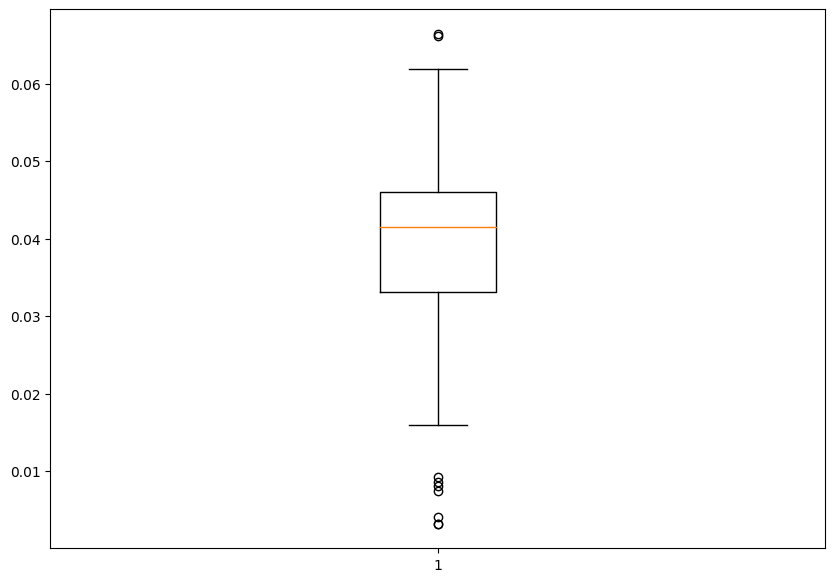

In [19]:
# TODO: Normalize all stats and calculate the variance of them
variance_list = []
variance_headers = []
min_max = []
for header in df.columns.values.tolist():
    data = df[header].values.tolist()
    if type(data[0]) is int or type(data[0]) is float:
        min_max.append((min(df[header].tolist()), max(df[header].tolist())))
        df[header] = pd.DataFrame(ScaleList(data), columns=[header])
        var = Variance(df[header].tolist())
        #print(header, ". ", str(var))
        variance_list.append(var)
        variance_headers.append(header)

#for i in range(len(variance_list)):
#    print(i, variance_headers[i], variance_list[i])
#    print("     ", min_max[i][0], min_max[i][1])

# box plot of varinaces
fig = plt.figure(figsize =(10, 7))
plt.boxplot(variance_list)
plt.show()


In [20]:
# parse through parameters and get rid of ones with low variance

threshold_min = .015  # from above box plot
threshold_max = .062  # from above box plot

low_var_columns = []
for i in range(len(variance_headers)):
    if variance_list[i] < threshold_min or variance_list[i] > threshold_max:
        low_var_columns.append(variance_headers[i])

print(low_var_columns)


['SIGNING AGE', '+/-', 'onIce_xGoalsPercentage', 'offIce_xGoalsPercentage', 'onIce_corsiPercentage', 'offIce_corsiPercentage', 'onIce_fenwickPercentage', 'offIce_fenwickPercentage', 'I_F_mediumDangerShots']


In [21]:
# remove parameters with a variance under our theshold

#df = df.drop(columns = low_var_columns)
print(df.columns.values.tolist())

['POS', 'TYPE', 'SIGNING AGE', 'CLAUSE', 'LENGTH', 'EXPIRY', 'CAP HIT %', 'PTS', 'G', 'A', 'PTS', '+/-', 'PIM', 'EV', 'PPG', 'SHG', 'GWG', 'SOG', 'SPCT', 'FOW', 'FOL', 'HIT', 'BL', 'icetime', 'shifts', 'onIce_xGoalsPercentage', 'offIce_xGoalsPercentage', 'onIce_corsiPercentage', 'offIce_corsiPercentage', 'onIce_fenwickPercentage', 'offIce_fenwickPercentage', 'I_F_xOnGoal', 'I_F_xGoals', 'I_F_primaryAssists', 'I_F_secondaryAssists', 'I_F_shotsOnGoal', 'I_F_blockedShotAttempts', 'I_F_shotAttempts', 'I_F_points', 'I_F_goals', 'I_F_penalityMinutes', 'I_F_faceOffsWon', 'I_F_hits', 'I_F_takeaways', 'I_F_giveaways', 'I_F_lowDangerShots', 'I_F_mediumDangerShots', 'I_F_highDangerShots', 'I_F_lowDangerxGoals', 'I_F_mediumDangerxGoals', 'I_F_highDangerxGoals', 'I_F_lowDangerGoals', 'I_F_mediumDangerGoals', 'I_F_highDangerGoals', 'I_F_unblockedShotAttempts', 'I_F_dZoneGiveaways', 'I_F_xGoalsFromxReboundsOfShots', 'I_F_xGoalsFromActualReboundsOfShots', 'I_F_reboundxGoals', 'I_F_xGoals_with_earned_r

In [22]:
# Make Model
from sklearn.model_selection import train_test_split

x = df.drop(["CAP HIT %", "LENGTH", "EXPIRY"], axis=1)
y1 = df["CAP HIT %"]
y2 = df["LENGTH"]
y3 = df["EXPIRY"]

# one hot encode categorical variables in x
categorical_columns = ['POS', 'TYPE', 'CLAUSE']
x = oneHot(x, categorical_columns)

# Set random seed
np.random.seed(46)

# Split into training and tets
X_train, X_test, y_train, y_test = train_test_split(x, y1, test_size=0.2)


In [23]:
# Normal Resgression Model
from sklearn.ensemble import RandomForestRegressor

norm_model = RandomForestRegressor()
norm_model.fit(X_train, y_train)
norm_model.score(X_test, y_test)

0.7980141800972291

In [24]:
# Ridge Resgression Model
from sklearn.linear_model import Ridge

ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_model.score(X_test, y_test)

0.8115343487101334

In [25]:
# Enssamble Resgression Model
from sklearn.ensemble import RandomForestRegressor

en_model = RandomForestRegressor(n_estimators=100)
en_model.fit(X_train, y_train)
en_model.score(X_test, y_test)

0.7833421938605141

In [26]:
# Lasso ElasticNet Regression Model (suppose to reduce overfitting)
from sklearn.linear_model import Lasso

lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_model.score(X_test, y_test)

# TODO: Hyperparameter Tuning

-0.06782544925550371

## Highest Accuracy Score: 81.15%

In [27]:
# Make Predictions
y_preds = ridge_model.predict(X_test)  # chose Ridge model because it outputted the highest score (R^2)

print(y_preds[:10])
print(np.array(y_test[:10]))



[0.33373791 0.30120005 0.94754051 0.36300299 0.18924761 0.16432396
 0.5173708  0.40390529 0.34428655 0.16348825]
[0.34730539 0.23952096 0.91616766 0.33532934 0.14371257 0.05389222
 0.4011976  0.28742515 0.17964072 0.05988024]


In [28]:
# Compare Preditions to the truth using Mean Absolute Error (MAE) and Mean Squared Error (MSE)

# errors = truth - prediction

# MAE = averages the absolte values of all the errors
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_preds)

# MSE = averages the squared values of all the errors
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_preds)